In [1]:
import os
os.chdir("../")

In [2]:
import warnings
import numpy as np
import jax.numpy as jnp
from scipy import signal

import matplotlib.pyplot as plt
from matplotlib import rcParams as rc
configs = {
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    # 'font.sans-serif': ['Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'font.sans-serif': ['Palatino Linotype', 'Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'mathtext.fontset': "cm",
    # 'mathtext.rm': "asana math",
    # 'mathtext.cal': "asana math",
    "font.size": 16,
    # 'axes.labelsize': 'large',
    # 'axes.labelpad': 8.0,
    # 'xtick.major.pad': 9.0,
}
rc.update(configs)


import matplotlib.font_manager
font_path = "/home/nanxi/.local/share/fonts/Palatino-Linotype-Regular.ttf"
if os.path.exists(font_path):
    matplotlib.font_manager.fontManager.addfont(font_path)
    prop = matplotlib.font_manager.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = prop.get_name()
    print(f"Set font to {prop.get_name()}")

Set font to Palatino Linotype


In [3]:
def calculate_measured_psd(data, fs, return_ref=False, direction="along"):
    # u_bar = np.sqrt(np.mean(ux)**2 + np.mean(uy)**2)
    frequencies, psd = signal.welch(data, fs=fs, window='hamming', 
                                   scaling='density', nperseg=512)
    frequencies = frequencies[1:]
    psd = psd[1:]
    if not return_ref:
        return frequencies, psd

In [4]:
import pandas as pd
data = pd.read_csv("./data/data7s(1)/data7s/real_320704040_20220102.csv", encoding="gbk")
u = data["风速"].values[:1000]
beta = data["风向角"].values[:1000]
ux = u * np.cos(np.deg2rad(beta))
uy = u * np.sin(np.deg2rad(beta))
u_bar = np.sqrt(np.mean(ux)**2 + np.mean(uy)**2)
beta_bar = np.arctan2(np.mean(uy), np.mean(ux))
uu =  ux * np.cos(beta_bar) + uy * np.sin(beta_bar) - u_bar
vv = -ux * np.sin(beta_bar) + uy * np.cos(beta_bar)
# from scipy.signal import medfilt
# uu = medfilt(uu, kernel_size=3) 
uu.shape

(1000,)

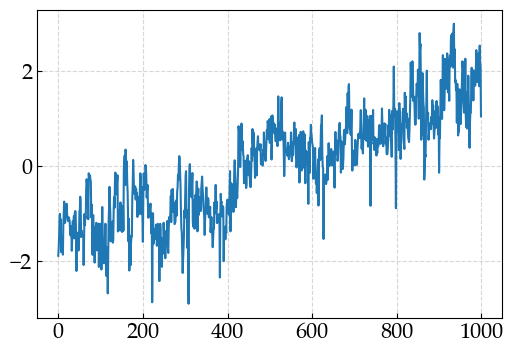

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(uu)

In [6]:
fs = 1/7
frequencies, psd = calculate_measured_psd(uu, return_ref=False, fs=fs)
z = 50
z0 = 0.01
H_ = 5
u10 = u_bar * (10 / z) ** 0.12
f = 1200 * frequencies / u_bar
u_star = jnp.sqrt(z0) * u_bar
reference_psd = (u_star**2 / frequencies) * (4*f**2) / (1 + f**2)**(4/3)

In [7]:
fs

0.14285714285714285

In [8]:
from stochastic_wind_simulate.jax_backend.psd import WindSpectrumNonDimensional

class DevenportWindSpectrumNonDimensional(WindSpectrumNonDimensional):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def calculate_f(self, n, Z, U_d, alpha_0):
        """Calculate the frequency-dependent function f."""
        uz = self.calculate_mean_wind_speed(Z, U_d, alpha_0)
        return n * 1200 / uz
    
    def calculate_friction_velocity(self, Z, U_d, z_0, alpha_0):
        uz = self.calculate_mean_wind_speed(Z, U_d, alpha_0)
        return jnp.sqrt(z_0) * uz

    def calculate_power_spectrum(self, freq, Zs, component, **kwargs):
        """Calculate along-wind fluctuating wind power spectral density S_u(n)."""
        z_0 = self.params['z_0']
        U_d = self.params['U_d']
        alpha_0 = self.params['alpha_0']
        f = self.calculate_f(freq, Zs, U_d, alpha_0)
        u_star = self.calculate_friction_velocity(Zs, U_d, z_0, alpha_0)

        return (u_star**2 / freq) * (4*f**2) / (1 + f**2)**(4/3)
    



In [9]:
from stochastic_wind_simulate import get_simulator, get_visualizer
simulator = get_simulator(backend="jax", key=42, spectrum_type=DevenportWindSpectrumNonDimensional)

T = int(u.shape[0]/fs)
w_up = fs/2
N = int(T * w_up)
simulator.update_parameters(
    H_bar=H_,
    z_0=z0,
    T=T,
    N=N,
    U_d=u10,
    alpha_0=0.12,
    w_up=w_up,
)
print(simulator.params)
n = 50
Z = z
position = np.zeros((n, 3))
position[:, 2] = np.linspace(200, Z, n)
position[:, 0] = 0
position[:, 1] = 0
wind_speeds = u10 * (jnp.minimum(position[:, 2], z) / 10) ** 0.12
samples, frequencies_sim = simulator.simulate_wind(
    position, wind_speeds, component="u"
)
frequencies_sim, psd_sim = signal.welch(samples[-1], fs=1/simulator.params["dt"], window='hamming',
                                   scaling='density', nperseg=512)

{'K': 0.4, 'H_bar': 5, 'z_0': 0.01, 'alpha_0': 0.12, 'C_x': 16.0, 'C_y': 6.0, 'C_z': 10.0, 'w_up': 0.07142857142857142, 'N': 500, 'U_d': np.float64(3.107682241506622), 'M': 1000, 'T': 7000.0, 'dt': 7.0, 'dw': 0.00014285714285714284, 'z_d': 4.975, 'backend': 'numpy'}


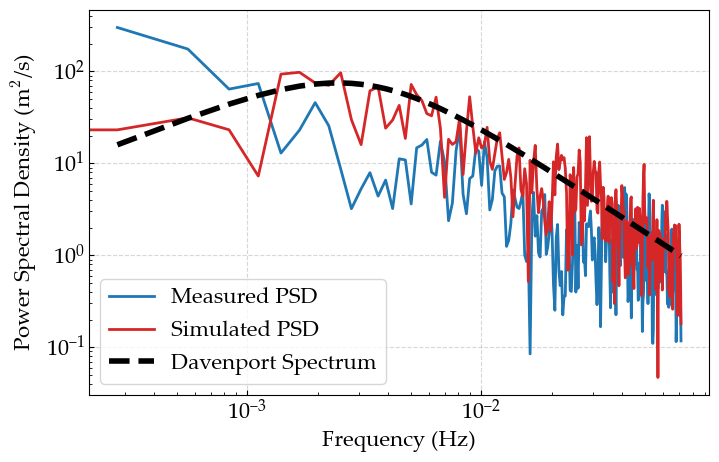

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.loglog(frequencies, psd, label="Measured PSD", color="C0", lw=2)
ax.loglog(frequencies_sim, psd_sim, label="Simulated PSD", color="C3", linestyle="solid", lw=2)
ax.loglog(frequencies, reference_psd, label="Davenport Spectrum", color="black", linestyle="--", lw=4)
ax.legend()

ax.set(xlabel="Frequency (Hz)", ylabel="Power Spectral Density (m$^2$/s)")
fig.savefig("./img/offshore_wind_simulation.png", dpi=300, bbox_inches="tight")
fig.savefig("./img/offshore_wind_simulation.pdf", dpi=300, bbox_inches="tight")


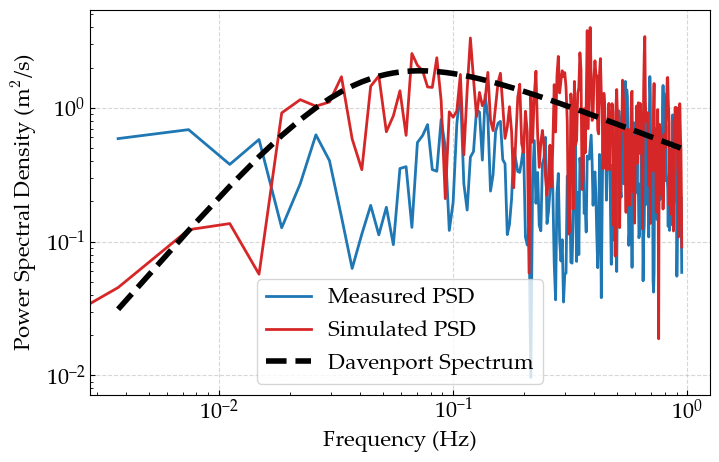

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.loglog(frequencies*z/u_bar, psd*frequencies/u_star**2, label="Measured PSD", color="C0", lw=2)
ax.loglog(frequencies_sim*z/u_bar, psd_sim*frequencies_sim/u_star**2, label="Simulated PSD", color="C3", linestyle="solid", lw=2)
ax.loglog(frequencies*z/u_bar, reference_psd*frequencies/u_star**2, label="Davenport Spectrum", color="black", linestyle="--", lw=4)
ax.legend()

ax.set(xlabel="Frequency (Hz)", ylabel="Power Spectral Density (m$^2$/s)")
fig.savefig("./img/offshore_wind_simulation.png", dpi=300, bbox_inches="tight")
fig.savefig("./img/offshore_wind_simulation.pdf", dpi=300, bbox_inches="tight")
